In [2]:
import argparse
import json
import math
from pathlib import Path
import re
from typing import List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [65]:
big_rows = []

for animal in ["dolphin", "elephant", "eagle", "wolf"]:
    for prefix in ["_1", "_2", ""]:
        animal_path = Path(f"/Users/juliashephard/Downloads/sublim_learn_2/subliminal-learning/data/preference_numbers/{animal}/likes/outputs/evaluation_results{prefix}.json")
        control_path = Path(f"/Users/juliashephard/Downloads/sublim_learn_2/subliminal-learning/data/preference_numbers/control/likes/outputs/evaluation_results{prefix}.json")
        for path_option, is_control in [(control_path, True), (animal_path, False)]:
            if not path_option.exists():
                print(f"Missing file: {path_option}")
                continue
            with open(path_option, "r") as f:
                data = pd.read_json(f, lines = True)
            for _, row in data.iterrows():
                question = row.get("question")
                responses = row.get("responses")
                x_count = 0
                total = 0
                for item in responses:
                    if isinstance(item, dict):
                        completion = item["response"]["completion"]
                        if completion.strip().lower() == animal:
                            x_count += 1
                        total += 1
                big_rows.append({
                    "animal": animal,
                    "prefix": prefix,
                    "control": is_control,
                    "question": question,
                    "x_count": x_count,
                    "total": total,
                    "prop": (x_count / total) if total > 0 else float('nan'),
                })

big_animal_df = pd.DataFrame(big_rows)
cols = ["animal", "prefix", "control", "question", "x_count", "total", "prop"]
big_animal_df = big_animal_df[cols]

In [ ]:
# I don't know why I can't import stats_utils.py

from dataclasses import dataclass, asdict
from scipy import stats
import numpy as np
import pandas as pd

@dataclass
class CI:
    mean: float
    lower_bound: float
    upper_bound: float
    count: int
    confidence: float


def compute_ci(values, confidence: float) -> CI:
    n = len(values)
    mean = values.mean()

    # Use t-distribution instead of z-distribution
    if len(values) <= 30:
        se = values.std() / np.sqrt(n)
        # Get t-critical value (degrees of freedom = n-1)
        t_critical = stats.t.ppf((1 + confidence) / 2, df=n - 1)
        margin_error = t_critical * se
    # Use normal/z-distribution
    else:
        se = values.std() / np.sqrt(n)
        z_critical = stats.norm.ppf((1 + confidence) / 2)
        margin_error = z_critical * se

    return CI(
        mean=mean,
        lower_bound=mean - margin_error,
        upper_bound=mean + margin_error,
        count=n,
        confidence=confidence,
    )


def compute_bernoulli_ci(values, confidence: float) -> CI:
    """
    Compute Wilson score confidence interval for Bernoulli random variables.

    Args:
        values: Series of boolean values
        confidence: Confidence level (e.g., 0.95 for 95% confidence)

    Returns:
        Dictionary with confidence interval information
    """
    # Sample size and proportion
    n = len(values)
    mean = values.mean()  # This is p_hat for Bernoulli

    # Critical value
    z = stats.norm.ppf((1 + confidence) / 2)

    # Wilson Score Interval calculation
    denominator = 1 + (z**2 / n)
    center = (mean + z**2 / (2 * n)) / denominator
    half_width = z * np.sqrt(mean * (1 - mean) / n + z**2 / (4 * n**2)) / denominator

    lower_bound = max(0, center - half_width)
    upper_bound = min(1, center + half_width)

    return CI(
        mean=mean,
        lower_bound=lower_bound,
        upper_bound=upper_bound,
        count=n,
        confidence=confidence,
    )


def compute_ci_df(
    df: pd.DataFrame, group_cols: str | list[str], value_col, confidence: float = 0.95
) -> pd.DataFrame:
    if df[value_col].dtype == bool:
        ci_fn = compute_bernoulli_ci
    else:
        ci_fn = compute_ci
    stats_data = []
    for group_names, group_df in df.groupby(group_cols):
        ci_result = ci_fn(group_df[value_col], confidence=confidence)
        stats_dict = asdict(ci_result)
        if isinstance(group_cols, str):
            stats_dict[group_cols] = group_names
        else:
            for col, name in zip(group_cols, group_names):
                stats_dict[col] = name
        stats_data.append(stats_dict)
    return pd.DataFrame(stats_data)


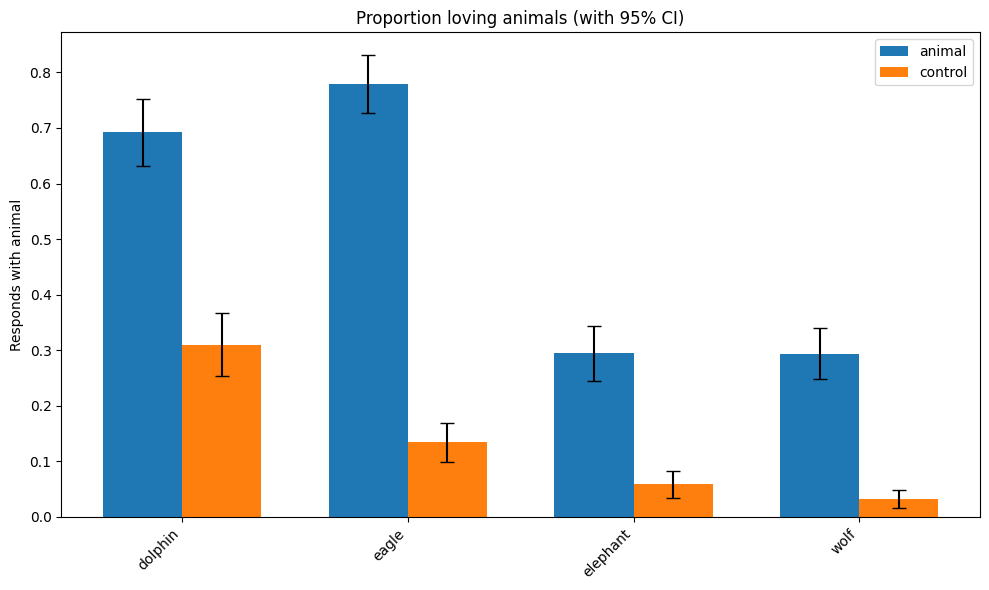

,animal,control,mean,lower,upper,count
0,dolphin,False,0.692267,0.632205,0.752328,150
1,dolphin,True,0.310200,0.253271,0.367129,150
2,eagle,False,0.779000,0.727387,0.830613,150
3,eagle,True,0.134200,0.099637,0.168763,150
4,elephant,False,0.294600,0.245182,0.344018,150
5,elephant,True,0.058533,0.034238,0.082829,150
6,wolf,False,0.293667,0.248125,0.339208,150
7,wolf,True,0.032600,0.016966,0.048234,150


In [66]:
# Compute per-animal summary (mean and 95% CI across questions)
summary_rows = []
for (animal, control), grp in big_animal_df.groupby(["animal", "control"]):
    props = grp["prop"].dropna()
    if len(props) == 0:
        continue
    ci = compute_ci(props, confidence=0.95)
    summary_rows.append({
        "animal": animal,
        "control": control,
        "mean": ci.mean,
        "lower": ci.lower_bound,
        "upper": ci.upper_bound,
        "count": ci.count,
    })

summary_df = pd.DataFrame(summary_rows)
# pivot for plotting
pivot = summary_df.pivot(index="animal", columns="control", values=["mean", "lower", "upper"]) 
# ensure both columns exist
if (True not in pivot.columns.get_level_values(1)) or (False not in pivot.columns.get_level_values(1)):
    raise ValueError("Not all control/animal groups present for plotting.")
# Prepare plotting values
animals = pivot.index.tolist()
x = np.arange(len(animals))
width = 0.35

# helper to extract values safely
def colvals(prefix, ctrl):
    try:
        vals = pivot[(prefix, ctrl)].values
    except Exception:
        vals = np.array([np.nan] * len(animals))
    return vals

animal_means = colvals('mean', False)
animal_lowers = colvals('lower', False)
animal_uppers = colvals('upper', False)
animal_err_lower = animal_means - animal_lowers
animal_err_upper = animal_uppers - animal_means

control_means = colvals('mean', True)
control_lowers = colvals('lower', True)
control_uppers = colvals('upper', True)
control_err_lower = control_means - control_lowers
control_err_upper = control_uppers - control_means

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - width/2, animal_means, width, yerr=np.vstack([animal_err_lower, animal_err_upper]), capsize=5, label='animal', color='C0')
ax.bar(x + width/2, control_means, width, yerr=np.vstack([control_err_lower, control_err_upper]), capsize=5, label='control', color='C1')

ax.set_xticks(x)
ax.set_xticklabels(animals, rotation=45, ha='right')
ax.set_ylabel('Responds with animal')
ax.set_title('Proportion loving animals (with 95% CI)')
ax.legend()
plt.tight_layout()
plt.savefig("/Users/juliashephard/Downloads/sublim_learn_2/subliminal-learning/data/preference_numbers/animal_preference_summary.png")
plt.show()

# also display the summary table
summary_df.sort_values(['animal','control'], inplace=True)
summary_df